# Artificial IntelligenceApplied toSatellite-based RemoteSensing Data for EarthObservation
## Chapter 7 - Example 2: Classification

The aim of this project is to implement a model able to classify simple object

Load the [NumPy](https://numpy.org/) library. NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays.

In [ ]:
import numpy as np

Load the [Matplotlib](https://matplotlib.org/) library. Matplotlib is a plotting library for the Python programming language and its numerical mathematics extension NumPy. It provides an object-oriented API for embedding plots into applications using general-purpose GUI toolkits like Tkinter, wxPython, Qt, or GTK+. There is also a procedural "pylab" interface based on a state machine (like OpenGL), designed to closely resemble that of MATLAB, though its use is discouraged. SciPy makes use of Matplotlib.

In [ ]:
import matplotlib.pyplot as plt

Load some functions from [Tensorflow.Keras](https://www.tensorflow.org/api_docs/python/tf/keras) library. Keras is an API designed for human beings, not machines. Keras follows best practices for reducing cognitive load: it offers consistent & simple APIs, it minimizes the number of user actions required for common use cases, and it provides clear & actionable error messages. It also has extensive documentation and developer guides. 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

## Create the dataset
For this simple project the dataset is created on-line. A common practice in Deep Learning is the use of generators. Basically a generator is composed of an infinite while loop and of the yield keyword. The generator is used to avoid memory problems, infact the datast is not loaded all in once, but batch by batch.

Before implementig the generator, the noise function is introduced. This function add noise for each group of 4 pixels, in RGB space. This function adds also a fake object.

In [ ]:
# Function that generates noise
def noise(noise_power=0.4):
  x = np.random.randint(4, high = 32 - 4)
  y = np.random.randint(4, high = 32 - 4)
  
  noise = np.random.random((32, 32, 3))*noise_power
  noise[x:x+4, y:y+4, ...] = np.random.randint(0, 2, size = 3)

  return noise

The generator, in this case, produces an RGB image of size (32, 32, 3) -> (width, height, channel), in which you can see a random object, the background noise and the fake (noise) object. The position of the objects is random.

In [ ]:
# Function for generating the dataset
def dataset_generator(batch_size = 16):
  img_shape = (32, 32, 3)
  object_size = 8 

  while True:
    x_train = np.zeros((batch_size, img_shape[0], img_shape[1], img_shape[2]))
    # The classes are represented by the colors
    y_train = np.zeros((batch_size, 6))

    for b in range(batch_size):

      selector = np.random.randint(0, high = 6, size = 1)

      x = np.random.randint(object_size, high = img_shape[0] - object_size)
      y = np.random.randint(object_size, high = img_shape[1] - object_size)
      
      # Create and object randomly (random position and random class)
      if selector == 1:
        # Red object
        x_train[b, x:x+object_size, y:y+object_size, 0] = 0.6
        y_train[b, 1] = 1.0
      elif selector == 2:
        # Green object
        x_train[b, x:x+object_size, y:y+object_size, 1] = 0.6
        y_train[b, 2] = 1.0
      elif selector == 3:
        # Blue object
        x_train[b, x:x+object_size, y:y+object_size, 2] = 0.6
        y_train[b, 3] = 1.0
      elif selector == 4:
        # Yellow object
        x_train[b, x:x+object_size, y:y+object_size, 0] = 0.5
        x_train[b, x:x+object_size, y:y+object_size, 1] = 0.5
        y_train[b, 4] = 1.0
      elif selector == 5:
        # Fuchsia object
        x_train[b, x:x+object_size, y:y+object_size, 0] = 0.5
        x_train[b, x:x+object_size, y:y+object_size, 2] = 0.5
        y_train[b, 5] = 1.0
      else:
        # No object
        x_train[b, ...] = 0
        y_train[b, 0] = 1.0
      
      # Add noise to the batches
      x_train[b, ...] = x_train[b, ...] + noise()
      x_train[b, ...] = np.clip(x_train[b, ...], 0.0, 1.0)
    
    yield x_train, y_train

To call the generator you should use the following commands

In [ ]:
# Initialize the generator
generator = dataset_generator(512) 

# Get the iterator from the generator 
iterator = iter(generator)

# Get a batch of data
x_train, y_train = next(iterator)

Define a vector with a label for each class

In [ ]:
classes = ['None', 'Red', 'Green', 'Blue', 'Yellow', 'Fuchsia']

Let plot an example.

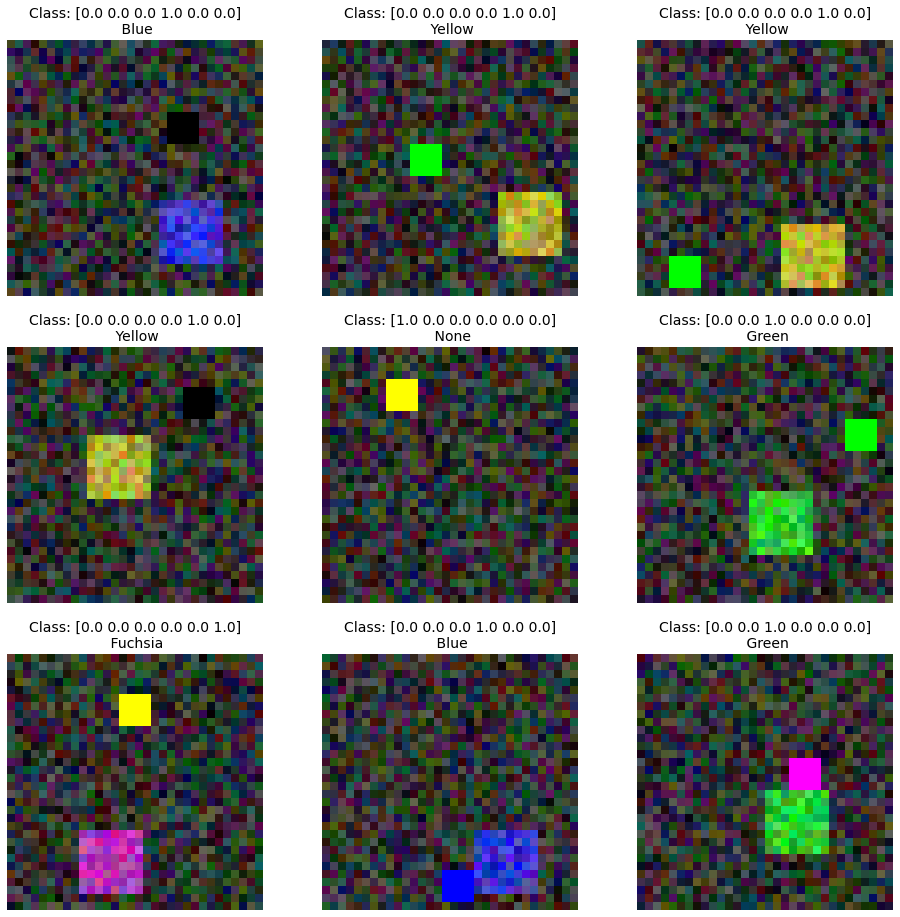

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize = (16, 16))
counter = 0
for i in range(3):
  for j in range(3):
    current =  y_train[counter, ...].tolist()
    c = classes[current.index(max(current))]
    axes[i,j].imshow(x_train[counter,...], cmap = 'gray')
    axes[i,j].set_title('Class: [%1.1f %1.1f %1.1f %1.1f %1.1f %1.1f]\n %s'  
                        % (y_train[counter, 0], y_train[counter, 1], y_train[counter, 2], y_train[counter, 3], y_train[counter, 4], y_train[counter, 5],c), fontsize=14)
    axes[i,j].axis(False)

    counter = counter + 1

plt.show()

# Build a model

The model is composed of different Dense layer, with a decreasing size, the ReLu as activation function (except for the last layer). As you can see before the first dense layer there is a Flatten layer. Since the input is a 3D matrix of size 32x32x3 and since the Dense layer is expecting a 1D vector, the flatten layer is necessary. This layer uroll the matrix in a 1D vector.

In [ ]:
model = Sequential()
model.add(Flatten(input_shape=(32, 32, 3)))
model.add(Dense(512, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(6, activation = 'softmax'))

Compile the model using the Binary Crossentropy as loss function and Adam as optimizer, and accuracy as extra metric.

In [ ]:
model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

Print the model structure

In [ ]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               1573376   
_________________________________________________________________
dense_6 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 102       
Total params: 1,648,438
Trainable params: 1,648,438
Non-trainable params: 0
____________________________________________

# Model training
The model will be trained with the function fit_generator, for 10 epcohs. This function uses generators, both for training and validations set. Since the generator are producing an infiniry of samples, using steps_per_epoch and validation_step, the user can define an arbitrary size for the dataset.

In [ ]:
history = model.fit_generator(
    dataset_generator(16),
    steps_per_epoch=1000//16,
    validation_data=dataset_generator(8),
    validation_steps=100//8,
    epochs = 10
)

Epoch 1/10
62/62 [==============================] - 1s 16ms/step - loss: 0.4523 - accuracy: 0.1845 - val_loss: 0.4238 - val_accuracy: 0.3333
Epoch 2/10
62/62 [==============================] - 1s 14ms/step - loss: 0.3908 - accuracy: 0.3216 - val_loss: 0.3917 - val_accuracy: 0.3125
Epoch 3/10
62/62 [==============================] - 1s 14ms/step - loss: 0.3252 - accuracy: 0.5131 - val_loss: 0.1764 - val_accuracy: 0.8333
Epoch 4/10
62/62 [==============================] - 1s 13ms/step - loss: 0.1706 - accuracy: 0.7863 - val_loss: 0.1260 - val_accuracy: 0.8125
Epoch 5/10
62/62 [==============================] - 1s 14ms/step - loss: 0.1619 - accuracy: 0.8024 - val_loss: 0.1248 - val_accuracy: 0.8229
Epoch 6/10
62/62 [==============================] - 1s 14ms/step - loss: 0.1255 - accuracy: 0.8468 - val_loss: 0.1178 - val_accuracy: 0.8646
Epoch 7/10
62/62 [==============================] - 1s 14ms/step - loss: 0.1248 - accuracy: 0.8538 - val_loss: 0.0711 - val_accuracy: 0.9375
Epoch 8/10
62

Plot the training score

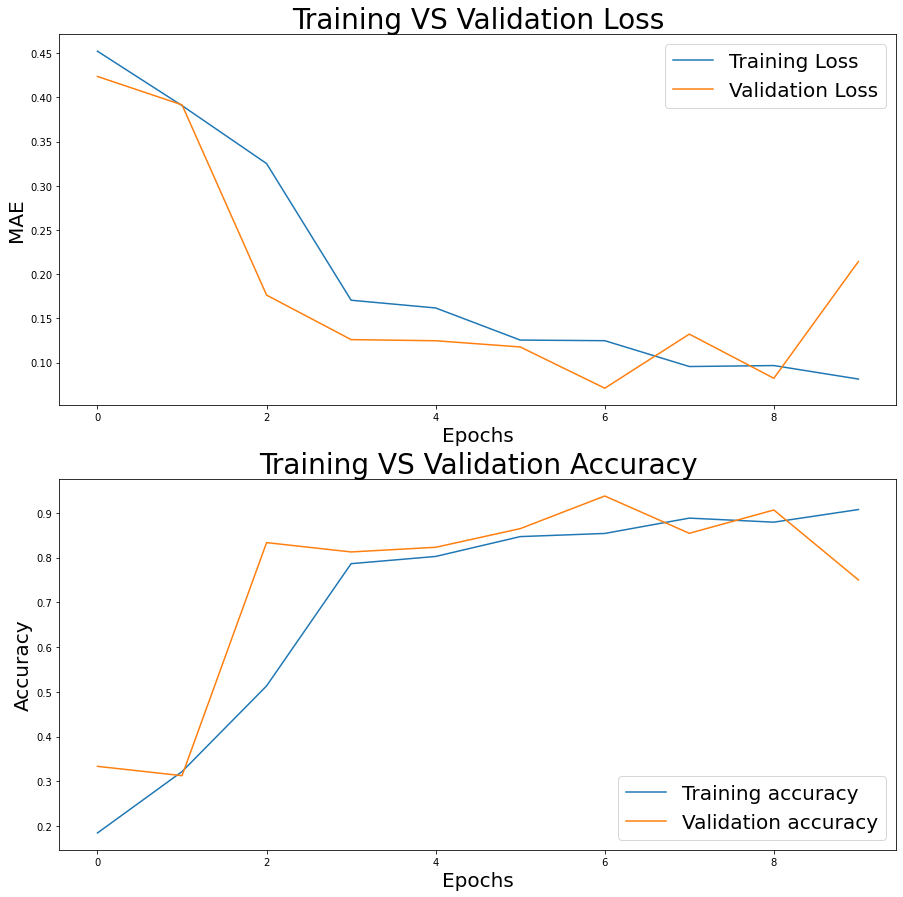

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (15, 15))
ax[0].plot(history.history['loss'], label = 'Training Loss')
ax[0].plot(history.history['val_loss'], label = 'Validation Loss')

ax[0].set_title('Training VS Validation Loss', fontsize = 28)
ax[0].set_xlabel('Epochs', fontsize = 20)
ax[0].set_ylabel('MAE', fontsize = 20)
ax[0].legend(fontsize = 20)

ax[1].plot(history.history['accuracy'], label = 'Training accuracy')
ax[1].plot(history.history['val_accuracy'], label = 'Validation accuracy')

ax[1].set_title('Training VS Validation Accuracy', fontsize = 28)
ax[1].set_xlabel('Epochs', fontsize = 20)
ax[1].set_ylabel('Accuracy', fontsize = 20)
ax[1].legend(fontsize = 20)

plt.show()

# Test the trained model

Load new samples through the generator and predict the output

In [ ]:
x_train, y_train = next(iter(dataset_generator(9)))
pred = model.predict(x_train)

Plot the results

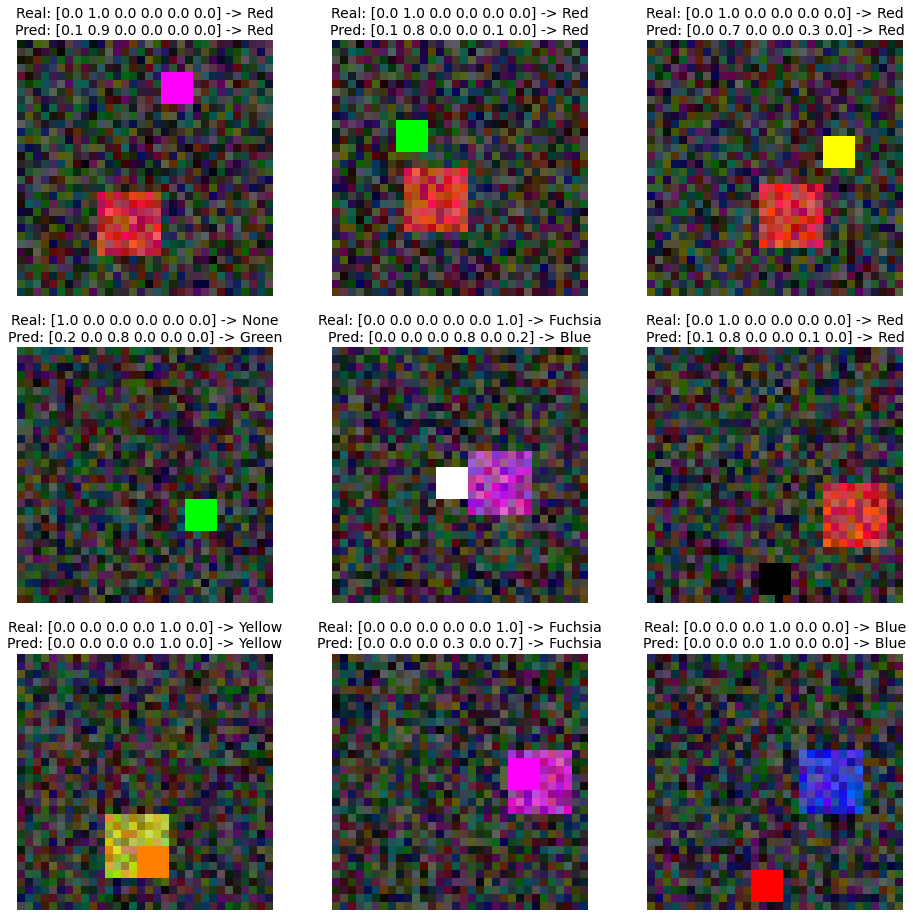

In [ ]:
ig, axes = plt.subplots(nrows=3, ncols=3, figsize = (16, 16))
counter = 0
for i in range(3):
  for j in range(3):

    current_real =  y_train[counter, ...].tolist()
    c_real = classes[current_real.index(max(current_real))]

    current_pred =  pred[counter, ...].tolist()
    c_pred = classes[current_pred.index(max(current_pred))]



    axes[i,j].imshow(x_train[counter,...], cmap = 'gray')
    axes[i,j].set_title('Real: [%1.1f %1.1f %1.1f %1.1f %1.1f %1.1f] -> %s\nPred: [%1.1f %1.1f %1.1f %1.1f %1.1f %1.1f] -> %s'  
                        % (y_train[counter, 0], y_train[counter, 1], y_train[counter, 2], y_train[counter, 3],
                            y_train[counter, 4], y_train[counter, 5], c_real ,pred[counter,0], pred[counter, 1],
                            pred[counter, 2], pred[counter, 3], pred[counter, 4], pred[counter, 5], c_pred), fontsize=14)
    axes[i,j].axis(False)
    counter = counter + 1

plt.show()

# Confusion matrix

In the field of machine learning and specifically the problem of statistical classification, a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix), also known as an error matrix, is a specific table layout that allows visualization of the performance of an algorithm, typically a supervised learning one (in unsupervised learning it is usually called a matching matrix). Each row of the matrix represents the instances in a predicted class while each column represents the instances in an actual class (or vice versa). The name stems from the fact that it makes it easy to see if the system is confusing two classes (i.e. commonly mislabeling one as another).

It is a special kind of contingency table, with two dimensions ("actual" and "predicted"), and identical sets of "classes" in both dimensions (each combination of dimension and class is a variable in the contingency table). 

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  import itertools
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')


  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title, fontsize = 28)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45, fontsize = 16)
  plt.yticks(tick_marks, classes, fontsize = 16)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black", fontsize = 16)

  plt.ylabel('True label', fontsize = 20)
  plt.xlabel('Predicted label', fontsize = 20)
  plt.tight_layout()
  plt.show()

# Get the labels from vector one hot encoded
def getLabels(one_hot_encoded):
  l = np.argmax(one_hot_encoded, axis=1)
  labels = []

  for i in range(one_hot_encoded.shape[0]):
    if l[i] == 0:
      labels.append('None')
    elif l[i] == 1:
      labels.append('Red')
    elif l[i] == 2:
      labels.append('Green')
    elif l[i] == 3:
      labels.append('Blue')
    elif l[i] == 4:
      labels.append('Yellow')
    elif l[i] == 5:
      labels.append('Fuchsia')

  return labels

Get more data

In [ ]:
x_train, y_train = next(iter(dataset_generator(2048)))
pred = model.predict(x_train)

Plot the confusion matrices (not normalized and normalized)

Confusion matrix, without normalization


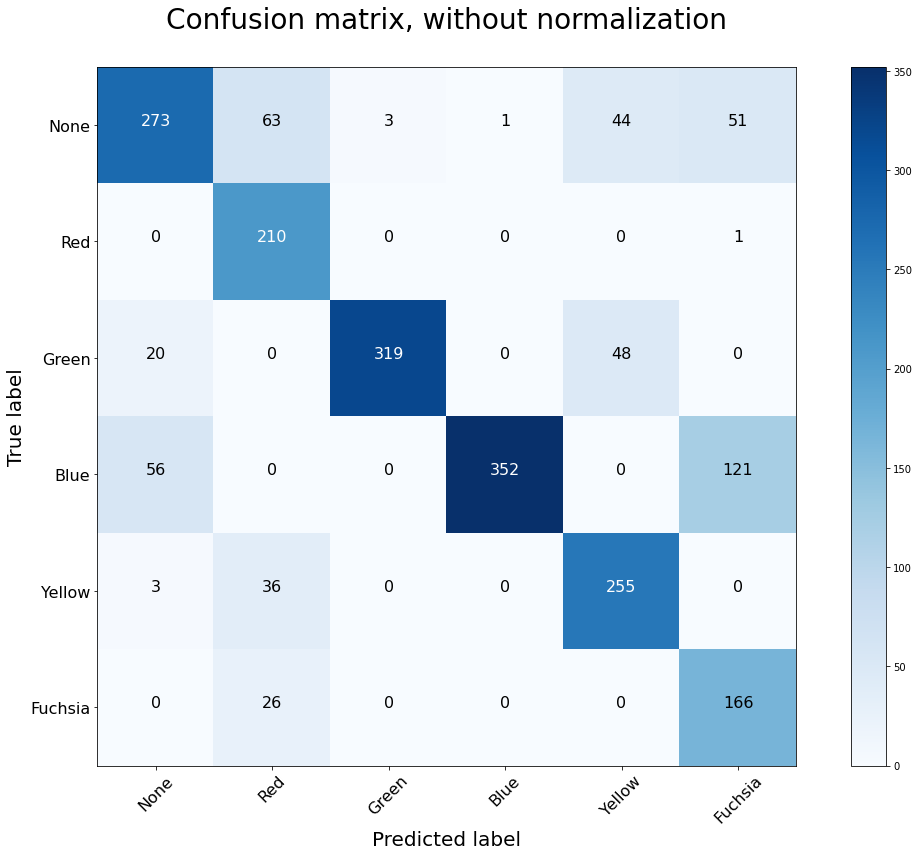

Normalized confusion matrix


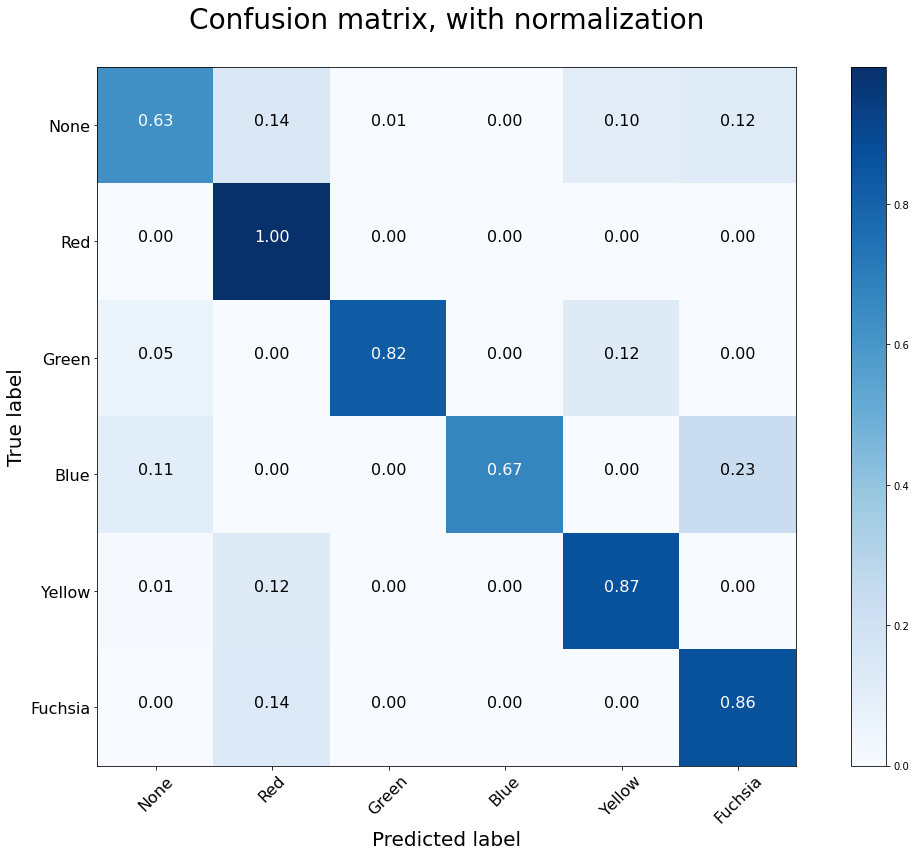

In [ ]:
pl = getLabels(pred)
cl = getLabels(y_train)

cm = confusion_matrix(pl, cl, classes)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(16, 12))
plot_confusion_matrix(cm, classes=classes, title='Confusion matrix, without normalization\n')

# Plot normalized confusion matrix
plt.figure(figsize=(16, 12))
plot_confusion_matrix(cm, classes=classes, normalize=True, title='Confusion matrix, with normalization\n')